In [ ]:
#%%writefile productos_vdcns.py
######## PROTOCOLO AUTOMATICO PARA LA GENERACION DE INDICES APLICADOS #######
#######        A AGUAS CONTINENTALES CON LANDSAT 8 Y SENTINEL 2        ######
######                                                                  #####
####                        Autor: Diego Garcia Diaz                     ####
###                      email: diegogarcia@ebd.csic.es                   ###
##                  GitHub: https://github.com/Digdgeo/VDCNS               ##
#                        Sevilla 01/08/2016-28/02/2018                      #

# coding: utf-8

import os, shutil, re, time, subprocess, pandas, sys, rasterio, fiona, urllib, sqlite3, math, ogr, shapely, pymongo
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdalconst
from datetime import datetime, date
from shapely.geometry import mapping, Polygon, MultiLineString, shape
from rasterstats import zonal_stats
from scipy import ndimage
from fiona.crs import from_epsg


class Product(object):
    
    
    '''Esta clase genera los productos necesarios para el proyecto (Clorofila, Ficocianina, Turbidez y cota 
    del agua en el embalse. Estos valores se incluiran en la base de datos de las escenas usadas en el proyecto)'''
    
    def __init__(self, ruta_nor):
        
        self.shape = shape
        self.ruta_escena = ruta_nor
        self.escena = os.path.split(self.ruta_escena)[1]
        self.nor = os.path.split(self.ruta_escena)[0]
        self.raiz = os.path.split(self.nor)[0] 
        #print(self.raiz)
        self.nor = os.path.join(self.raiz, os.path.join('nor', self.escena))
        #print(self.nor)
        self.pro = os.path.join(self.raiz, 'pro')
        #print(self.pro)
        self.pro_escena = os.path.join(self.pro, self.escena)
        if not os.path.exists(self.pro_escena):
            os.makedirs(self.pro_escena)
        self.ori = os.path.join(self.raiz, os.path.join('ori', self.escena))
        self.data = os.path.join(self.raiz, 'data')
        self.temp = os.path.join(self.data, 'temp')
        self.dtm_mtn = os.path.join(self.data, 'dtm_mtn.tif')
        self.dtm_lidar = r'C:\Users\Diego\Desktop\VDCNS\LIDAR\MDT05_LIDAR.tif' #os.path.join(self.data, 'lidar_318.tif')
        self.dtm_2006 = os.path.join(self.data, 'mdt_2006_rec.tif')
        self.vals = {}
        self.d = {}
        self.cota = 0
        
        if 'l8oli' in self.escena:
            self.sat = 'L8'
        elif 'l7etm' in self.escena:
            self.sat = 'L7'
        elif 'l5tm' in self.escena:
            self.sat = 'L5'
        elif 'l4tm' in self.escena:
            self.sat = 'L4'
        else:
            print('no reconozco el satelite')

        if self.sat == 'L8':

            for i in os.listdir(self.nor):
                if re.search('img$', i):
                    
                    banda = i[-6:-4]
                                        
                    if banda == 'b2':
                        self.b2 = os.path.join(self.nor, i)
                    elif banda == 'b3':
                        self.b3 = os.path.join(self.nor, i)
                    elif banda == 'b4':
                        self.b4 = os.path.join(self.nor, i)
                    elif banda == 'b5':
                        self.b5 = os.path.join(self.nor, i)
                    elif banda == 'b6':
                        self.b6 = os.path.join(self.nor, i)
                    elif banda == 'b7':
                        self.b7 = os.path.join(self.nor, i)
                   
        else:

            for i in os.listdir(self.nor):
                if re.search('img$', i):
                    
                    banda = i[-6:-4]
                                        
                    if banda == 'b1':
                        self.b1 = os.path.join(self.nor, i)
                    elif banda == 'b2':
                        self.b2 = os.path.join(self.nor, i)
                    elif banda == 'b3':
                        self.b3 = os.path.join(self.nor, i)
                    elif banda == 'b4':
                        self.b4 = os.path.join(self.nor, i)
                    elif banda == 'b5':
                        self.b5 = os.path.join(self.nor, i)
                    elif banda == 'b7':
                        self.b7 = os.path.join(self.nor, i)
                        

            
                        
                        
    def get_stats(self):
        
        '''Este metodo se encarga de extraer los valores estadisticos de un shape con respecto a un raster'''
        print('Getting statistics')
        
        for i in os.listdir(self.pro_escena):
            if i.endswith('_WaterMask.shp'):
        
                shape = os.path.join(self.pro_escena, i)
        
        
        stats_mtn = zonal_stats(shape, self.dtm_mtn, \
                    stats=['majority', 'median', 'mean', 'max', 'min', 'range'])
        
        stats_lidar = zonal_stats(shape, self.dtm_lidar, \
                    stats=['majority', 'median', 'mean', 'max', 'min', 'range'])
        
        stats_2006 = zonal_stats(shape, self.dtm_2006, \
                    stats=['majority', 'median', 'mean', 'max', 'min', 'range'])
        
        print(stats_mtn[0], '\n', stats_lidar[0], '\n', stats_2006[0], '\n')
        
        self.cota = stats_mtn[0]['median']
        
        ##Insertamos los datos en MongoDB
        connection = pymongo.MongoClient("mongodb://localhost")
        db=connection.teledeteccion
        vdcns = db.vdcns
        
        try:
        
            vdcns.update_one({'_id':self.escena}, {'$set':{'Cota': {'MTN': stats_mtn[0], 'LIDAR': stats_lidar[0],\
                                                                    'JEX2006': stats_2006[0]}}}) 
            
        except Exception as e:
            
            print("Unexpected error:", type(e), e) 
                        
class get_water_level(Product):
    
    '''En esta clase se implementa todo el codigo necesario para llevar a cabo la generacion 
    de las laminas de agua con su cota asignada'''
                        
    def get_water_rec(self, shape):

        '''Primero hacemos el recorte a la cota 318, habria que introducir la ruta del shape
        con el cual queramos hacer el recorte'''
                
        if self.sat == 'L8':
            banda = self.b6

        else:
            banda = self.b5
            print(banda)
                    
            #except Exception as e:
                #print('Error', e)
                #print('No ha NIR noramlizado en la escena', self.escena)
                
        #print('banda', banda, self.sat)     
        #shape = r'O:\VDCNS\protocolo\data\cota_318p.shp'
        salida = os.path.join(self.pro_escena, self.escena + '_water_rec_b5.img')
        cmd = ["gdalwarp", "-dstnodata" , "0" , "-cutline", "-crop_to_cutline", "-tr", "30", "30", "-of", "ENVI", "-tap"]
        
        cmd.append(banda)
        cmd.append(salida)
        cmd.insert(4, shape) #seria el 4/2 con/sin el dst nodata
        #print(cmd)
        proc = subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stdout,stderr=proc.communicate()
        exit_code=proc.wait()

        if exit_code: 
            raise RuntimeError(stderr)
        else:
            print(stdout)
            print('recorte de la banda', banda[-6:-4], 'generado')
                

    def reclass_water(self):

        '''Hacemos el reclassify a las bandas recortadas para '''
        reclass = os.path.join(self.pro_escena, self.escena + '_water_reclass.img')
        print(reclass)
        
        for i in os.listdir(self.pro_escena):
            
            if re.search('_water_rec_b..img$', i):

                raster = os.path.join(self.pro_escena, i)

        with rasterio.open(raster) as src:
            B5 = src.read()

            B5[(B5 <= 1450) & (B5 > 0)] = 1
            B5[B5 > 1450] = 0
            
            profile = src.meta
            profile.update(dtype=rasterio.int16)

        with rasterio.open(reclass, 'w', **profile) as dst:
            dst.write(B5.astype(rasterio.int16))
    
    
    def get_clouds(self, shape):
        
        '''Este metodo sirve para hacer el recorte a la mascara de nubes y llevarla a la carpeta de la
        escena en pro para usarla luego al obtener los valores del contacto agua-tierra'''
        
        out = os.path.join(self.pro_escena, self.escena + '_nubes.img')
        print(out)
        for i in os.listdir(self.ori):
            if re.search('Fmask.img$', i):
                cloud = os.path.join(self.ori, i)
        
        cmd = ["gdalwarp", "-dstnodata" , "0" , "-cutline", "-crop_to_cutline", "-tr", "30", "30", "-of", "ENVI", "-tap"]
        
        cmd.append(cloud)
        cmd.append(out)
        cmd.insert(4, shape) #seria el 4/2 con/sin el dst nodata
        #print(cmd)
        proc = subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stdout,stderr=proc.communicate()
        exit_code=proc.wait()

        if exit_code: 
            raise RuntimeError(stderr)
        else:
            print(stdout)
            print('recorte de la mascara de nubes generado')
            
            
    def reclass_water_3classes(self):

        '''Hacemos el reclassify a las bandas recortadas para '''
        reclass = os.path.join(self.pro_escena, self.escena + '_water_reclass_3.img')
        print(reclass)
        
        for i in os.listdir(self.pro_escena):
            
            if re.search('_water_rec_b..img$', i):

                raster = os.path.join(self.pro_escena, i)
                
            elif re.search('_nubes.img$', i):
                nubes = os.path.join(self.pro_escena, i)
                
        #Vamos a usar la mascara de nubes para pasar esos valores a NoData y evitar posibles nubes o sombras en el agua
        with rasterio.open(nubes) as clouds:
            NUBES = clouds.read()
            
        with rasterio.open(raster) as src:
            B5 = src.read()

            B5[(B5 <= 1450) & (B5 > 0)] = 1
            B5[B5 > 1450] = 2
            B5[(NUBES == 2) | (NUBES == 4)] = 0
            
            profile = src.meta
            profile.update(dtype=rasterio.int16)

        with rasterio.open(reclass, 'w', **profile) as dst:
            dst.write(B5.astype(rasterio.int16))
        
        
    def get_edges(self):
        
        '''Este metodo sirve para obtener la franja de pixeles de contacto entre agua y tierra.
        Necesita tener la mascara de nubes para asignar los valores de nubes y sombras a NoData'''
        
        out = os.path.join(self.pro_escena, self.escena + '_edges.img')
        print(out)
        for i in os.listdir(self.pro_escena):
            if re.search('reclass_3.img$', i):
                b5 = os.path.join(self.pro_escena, i)
        
        with rasterio.open(b5) as src:
            B5 = src.read()

        B4 = B5.reshape(453, 484)
        B3 = np.where(B4 != 1, 0, B4)
                
        mask = ((B3 != 1))
        mask2 = ((B4 != 1))
        
        struct = ndimage.generate_binary_structure(2, 2)
        erode = ndimage.binary_erosion(B3, struct)
        edges = mask ^ erode
        #e = edges.reshape(1, 453, 484)
        
        #Probamos a hacer la ternaria
        struct2 = ndimage.generate_binary_structure(2, 2)
        erode2 = ndimage.binary_erosion(B4, struct2)
        edges2 = mask2 ^ erode2
        #e2 = edges2.reshape(1, 453, 484)

        edges3 = np.where((edges2 == 1) & (edges == 0), 1, 0)
        e3 = edges3.reshape(1, 453, 484)

        profile = src.meta
        profile.update(dtype=rasterio.int32)

        with rasterio.open(out, 'w', **profile) as dst:
            dst.write(e3.astype(rasterio.int32))

    
    def polygonize(self):
        
        '''Este metodo sirve para vecorizar la lamina de agua obtenida'''
            
        outShp = os.path.join(self.pro_escena, self.escena + '_poly.shp')

        for i in os.listdir(self.pro_escena):
            if re.search('water_reclass.img$', i):
                print(i)
                water = os.path.join(self.pro_escena, i)

        sourceRaster = gdal.Open(water)
        band = sourceRaster.GetRasterBand(1)
        bandArray = band.ReadAsArray()

        driver = ogr.GetDriverByName("ESRI Shapefile")
        if os.path.exists(outShp):
            driver.DeleteDataSource(outShp)
        outDatasource = driver.CreateDataSource(outShp)
        outLayer = outDatasource.CreateLayer("polygonized", srs= None)
        gdal.Polygonize( band, None, outLayer, -1, [], callback=None )
        outDatasource.Destroy()
        sourceRaster = None
            
    def get_vector_mask_pg(self):
        
        '''Este metodo sirve para seleccionar la lamina de agua vectorial adecuada (la que tenga la segunda mayor area)'''
        
        out = os.path.join(self.pro_escena, self.escena[:8] + '_watervec.shp')
        
        for i in os.listdir(self.pro_escena):
            if i.endswith('poly.shp'):
                shp = os.path.join(self.pro_escena, i)
                
        myshp = fiona.open(shp)

        areas = []
        selection = []

        for i in myshp.values():

            geom1 = i['geometry']
            a1 = Polygon(geom1['coordinates'][0])
            #print('\nArea', a1.area, '\n')
            areas.append(a1.area)

        #print(sorted(areas))

        for i in myshp.values():

            geom1 = i['geometry']
            a1 = Polygon(geom1['coordinates'][0])

            if a1.area == sorted(areas)[-2]:
                selection.append(i)


        with fiona.open(shp, 'r') as source:

            # **source.meta is a shortcut to get the crs, driver, and schema
            # keyword arguments from the source Collection.
            with fiona.open(out, 'w', **source.meta) as sink:


                for f in source:

                    geom1 = f['geometry']
                    a1 = Polygon(geom1['coordinates'][0])
                    if a1.area == sorted(areas)[-2]:
                        sink.write(f)
        
    def get_vector_mask_pl(self, ratio):
        
        '''En este metodo elegimos el poligono de la mascara de agua y 
        lo pasamos a vectorial (suavizando tambien la geometria)'''
        
        outshp = os.path.join(self.pro_escena, self.escena[:10] + '_WaterMask.shp')
        
        for i in os.listdir(self.pro_escena):
            
            if i.endswith('_watervec.shp'):
                
                shape = os.path.join(self.pro_escena, i)
                print(shape)
                myshp = fiona.open(shape)
            
        for i in myshp:
            geom1 = i['geometry']
            #print(geom1)
            #print(geom1)
            line = MultiLineString(geom1['coordinates'])
            line10 = line.simplify(ratio)
        

        # Define a polygon feature geometry with one attribute
        schema = {
            'geometry': 'MultiLineString',
            'properties': {'id': 'int'}}

        # Write a new Shapefile
        with fiona.open(outshp, 'w', 'ESRI Shapefile', schema) as c:
            ## If there are multiple geometries, put the "for" loop here
            c.write({
                'geometry': mapping(line10),
                'properties': {'id': 123},
            })
                
    def get_contour(self):
        
        '''En este metodo creamos una copia de la linea de agua con la cota ya asignada'''
        
        outshp = os.path.join(self.pro_escena, self.escena[:8] + '_contour.shp')
        
        for i in os.listdir(self.pro_escena):
            if i.endswith('_WaterMask.shp'):
                myshp = fiona.open(os.path.join(self.pro_escena, i))
        
        for i in myshp:
            
            geom1 = i['geometry']
            #print(geom1)
            #print(geom1)
            line = MultiLineString(geom1['coordinates'])
            

        # Define a polygon feature geometry with one attribute
        schema = {
            'geometry': 'MultiLineString',
            'properties': {'id': 'str', 'cota': 'float'}}
        
        # Write a new Shapefile
        with fiona.open(outshp, 'w', crs=from_epsg(25830),driver='ESRI Shapefile', schema=schema) as c:
            ## If there are multiple geometries, put the "for" loop here
            c.write({
                'geometry': mapping(line),
                'properties': {'id': self.escena, 'cota': self.cota},
            })

            
            
    def get_depth(self):
                
        '''Este metodo sirve para generar un mapa con la profundidad de la inundación'''
        
        outfile = os.path.join(self.pro_escena, self.escena[:8] + '_depth.img' )
        
        for i in os.listdir(self.pro_escena):
            #print(i)
            if re.search('_reclass_3.img$', i):
                agua = os.path.join(self.pro_escena, i)
                print(agua)
                
        dtm = r'O:\VDCNS\Curvas_MTN_Historico\mdt_comp1.tif' #El dtm que se a usar, el compuesta pre y postpir pasado  30 metros!
        
        for i in os.listdir(self.pro_escena):
            if i.endswith('contour.shp'):
                contour = os.path.join(self.pro_escena, i)

        #cogemos la cota del agua del shape
        myshp = fiona.open(contour)

        for i in myshp:
            cota = i['properties']['cota']
            print(cota)

        with rasterio.open(agua) as water:
            WT = water.read()
            WT[WT != 1] = 0

            Water_High = np.where(WT == 1, cota, 0)

        with rasterio.open(dtm) as mdt:
            DTM = mdt.read()
            DTM[WT != 1] = np.nan

            depth = Water_High - DTM
            depth[depth < 0] = 0
            depth[depth > 50] = 0

            profile = water.meta
            profile.update(dtype = rasterio.float32)

            with rasterio.open(outfile, 'w', **profile) as dst:
                dst.write(depth.astype(rasterio.float32))
        
        
    def reclass_depth(self):
        
        '''Este metodo sirve para reclasificar las profundidades en los 4 rangos necesarios: 0,5, 1, 2 y 5 metros.
        En principio se va a hacer solo un raster con valores del 1 (5 metros) al 4 (0,5 metros)'''
        
        outfile = os.path.join(self.pro_escena, self.escena[:8] + '_depth_reclass.img' )
        
        for i in os.listdir(self.pro_escena):
            if i.endswith('depth.img'):
                depth = os.path.join(self.pro_escena, i)
                print(depth)
        
        with rasterio.open(depth) as dpth:
            
            DEPTH = dpth.read()
            a = np.where(DEPTH < 0.5, 4, DEPTH)
            b= np.where(((a >= 0.5) & (a < 1)), 3, a)
            c = np.where(((b >= 1) & (b < 2)), 2, a)
            d = np.where(((c >= 2) & (c < 5)), 1, a)
            e = np.where(d >= 5, 5, a)
                

            profile = dpth.meta
            profile.update(dtype = rasterio.float32)

            with rasterio.open(outfile, 'w', **profile) as dst:
                dst.write(e.astype(rasterio.float32))
                
        
    def run_water_mask(self):
        
        '''Este metodo llama a todos los necesarios para otener los productos'''
        
        self.get_water_rec(r'O:\VDCNS\protocolo\data\cota_318p.shp')
        self.reclass_water()
        self.polygonize()
        self.get_vector_mask_pg()
        self.get_vector_mask_pl(0)
        self.get_stats()
        self.get_clouds(r'O:\VDCNS\protocolo\data\cota_318p.shp')
        self.reclass_water_3classes()
        self.get_edges()
        self.get_contour()
        self.get_depth()
        self.reclass_depth()
        
        

In [ ]:
shape = r'O:\VDCNS\protocolo\data\cota_318p.shp'
raster = r'O:\VDCNS\protocolo\pro\20070910l5tm202_32'

a = get_water_level(raster)
#a.run_water_mask()

In [ ]:
'''a.get_water_rec(shape)
a.reclass_water()
a.polygonize()
a.get_vector_mask_pg()'''
a.get_depth()
a.reclass_depth()

In [ ]:
ruta = r'O:\VDCNS\protocolo\nor'
shape = r'O:\VDCNS\protocolo\data\cota_318p.shp'

for i in os.listdir(ruta):
    
    try:
        
        a = get_water_level(os.path.join(ruta, i))
        a.get_depth()
        a.reclass_depth()
    except Exception as e:
        print(e)
        continue

In [ ]:
rutanor = r'O:\VDCNS\protocolo\nor'

suma = 0
b6 = 0
b5 = 0

for i in os.listdir(rutanor):
    ndir = os.path.join(rutanor, i)
    total = 0
    for f in os.listdir(ndir):
        total += 1
        if total == 19:
            suma += 1
        elif 'l8oli' in ndir:
            if f.endswith('b6.img'):
                b6 += 1
        else:
            if f.endswith('b5.img'):
                b5 += 1

In [ ]:
import os, rasterio, fiona
import numpy as np

agua = r'H:\VDCNS\protocolo\pro\19840910l5tm202_32\19840910l5tm202_32_water_reclass_3.img'
dtm = r'H:\VDCNS\protocolo\data\dtm_mtn_30'
outfile = r'H:\VDCNS\protocolo\pro\19840910l5tm202_32\depth2.img'

for i in os.listdir(os.path.split(agua)[0]):
    if i.endswith('contour.shp'):
        contour = os.path.join(os.path.split(agua)[0], i)
        
#cogemos la cota del agua del shape
myshp = fiona.open(contour)

for i in myshp:
    cota = i['properties']['cota']
    
    
with rasterio.open(agua) as water:
    WT = water.read()
    WT[WT != 1] = 0
    
    Water_High = np.where(WT == 1, cota, 0)

with rasterio.open(dtm) as mdt:
    DTM = mdt.read()
    DTM[WT != 1] = np.nan
    
    depth = Water_High - DTM
    
    profile = water.meta
    profile.update(dtype = rasterio.float32)
    
    with rasterio.open(outfile, 'w', **profile) as dst:
        dst.write(depth.astype(rasterio.float32))
    
    
    

# Reclass para Bruno, quitar de aqui

In [ ]:
import rasterio, os
import numpy as np

costes = r'E:\bruno\Fsil_Friction_10m_ext2.tif'
buffer = r'E:\bruno\Fsil_friction_dis_500mbuff_clip_rst.tif'
costes_mod = r'E:\bruno\Fsil_friction_dis_500mbuff_clip_rst_mod_final.img'

    
with rasterio.open(buffer) as bf:
    
    BUFFER = bf.read()
    #print(BUFFER.shape)

with rasterio.open(costes) as cost:
    
    COSTES = cost.read()
    COSTES[COSTES < 0] = 0
    COSTES[(BUFFER == 1.0) & (COSTES == 5)] = 1
    COSTES[(BUFFER == 1.0) & (COSTES == 10)] = 5
    COSTES[(BUFFER == 1.0) & (COSTES == 50)] = 10  
    #costes = np.where(((BUFFER == 1) & (COSTES == 50)), 10, COSTES)
    
    profile = cost.meta
    profile.update(dtype = rasterio.float32)

    with rasterio.open(costes_mod, 'w', **profile) as dst:
        dst.write(COSTES.astype(rasterio.float32))

# Run viewshed multipoints

In [ ]:
import os, arcpy

ruta = r'U:\marina_valdecanas\capas\CuencasVisuales\split'
points = []

for pt in os.listdir(ruta):
    if pt.endswith('.shp'):
        points.append(os.path.join(ruta, pt))
                      

        #arcpy.SelectLayerByAttribute_management ("pts", "NEW_SELECTION", '"FID" = {}'.format(fid))
for shp in points[:10]:
    
    outViewshed = arcpy.sa.Viewshed(inDem, shp, 1, 'CURVED_EARTH', 0.15)
    outViewshed.save(os.path.join(r'C:\Users\Diego\Desktop\delete', shp[:-4] + '.tif'))

In [ ]:
depth = r'O:\VDCNS\protocolo\pro\19870412l5tm202_32\19870412_depth2.img'
out = r'O:\VDCNS\protocolo\pro\19870412l5tm202_32\19870412_depth2_reclassA.img'

with rasterio.open(depth) as dpth:
            
    DEPTH = dpth.read()
    a = np.where(DEPTH < 0.5, 4, DEPTH)
    b= np.where(((a >= 0.5) & (a < 1)), 3, a)
    c = np.where(((b >= 1) & (b < 2)), 2, a)
    d = np.where(((c >= 2) & (c < 5)), 1, a)
    e = np.where(d >= 5, 5, a)
                
    

    profile = dpth.meta
    profile.update(dtype = rasterio.float32)

    with rasterio.open(out, 'w', **profile) as dst:
        dst.write(e.astype(rasterio.float32))

# Reclass Cost Path (Bruno)

In [ ]:
import os, rasterio

ruta = r'G:\GatoM'
out = os.path.join(ruta, 'ori_fri.img')

for i in os.listdir(ruta):
    
    if '250mb' in i and len(i) == 24:
        oribf = os.path.join(ruta, i)
        print('Ori:', oribf)
    elif '250mb_10ha' in i:
        bf10ha = os.path.join(ruta, i)
        print('10ha', bf10ha)
    elif '250mb_3ha' in i:
        bf3ha = os.path.join(ruta, i)
        print('3ha', bf3ha)
    elif 'friction_dis' in i:
        friori = os.path.join(ruta, i)
    elif 'friction_' in i and i.endswith('_10ha.tif'):
        fri10ha = os.path.join(ruta, i)
    elif 'friction_' in i and i.endswith('_3ha.tif'):
        fri3ha = os.path.join(ruta, i)
    else:
        continue

with rasterio.open(oribf) as bfori:       
    ORIBF = bfori.read()

with rasterio.open(friori) as orifri:      
    FRIORI = orifri.read()
    
    #reclasificamos
    #COSTES[COSTES < 0] = 0
    FRIORI[(ORIBF == 1) & (FRIORI == 5)] = 1
    FRIORI[(ORIBF == 1) & (FRIORI == 10)] = 5
    FRIORI[(ORIBF == 1) & (FRIORI == 50)] = 10  
                

    profile = orifri.meta
    profile.update(dtype = rasterio.float32)

    with rasterio.open(out, 'w', **profile) as dst:
        dst.write(FRIORI.astype(rasterio.float32))

In [ ]:
import os, rasterio, re

ruta = r'G:\def'

#Gato = {}
#species = {'Fsil': {}}
species2 = {'Fsil': {},  'Ggen': {}, 'Hich': {}, 'Mfoi': {}}


for k, v in species2.items():
    print(k)
    for i in os.listdir(ruta):
        #Ggen_250mb_3ha_def_areas.tif
        
        if i[:4] == k:
            #Oris
            if '250mb' in i and len(i) == 24:
                bf250 = os.path.join(ruta, i)
                #print(i)
            elif '500mb' in i and len(i) == 24:
                bf500 = os.path.join(ruta, i)
                #print(i)
            elif 'Friction_dis' in i and i.endswith('.tif'):
                #print(i)
                species2[k][os.path.join(ruta, i)] = [bf250, bf500]
                #print(species2.items())
            elif '250mb_3ha' in i and i.endswith('.tif'):
                #print('3HA', i)
                bf2503 = os.path.join(ruta, i)
                print(bf2503)   
            elif '500mb_3ha' in i and i.endswith('.tif'):
                bf5003 = os.path.join(ruta, i)
                print(bf5003)
            elif 'Friction_10m_3ha' in i and i.endswith('.tif'):
                print('Friction3HAAAAAAAA', os.path.join(ruta, i))
                species2[k][os.path.join(ruta, i)] = [bf2503, bf5003]
                
            #10ha
            elif '250mb_10ha' in i and i.endswith('.tif'):
                bf25010 = os.path.join(ruta, i)
                
            elif '500mb_10ha' in i and i.endswith('.tif'):
                bf50010 = os.path.join(ruta, i)
                
            elif 'Friction_10m_10ha' in i and i.endswith('.tif'):
                
                species2[k][os.path.join(ruta, i)] = [bf25010, bf50010]

In [ ]:
for k, v in species2.items():
    print(k, v)

In [ ]:
def reclass(d):
    
    for i in os.listdir(ruta):
        
        if 'Friction_dis' in i and i[:4] == 'Fsil':
                out = os.path.join(ruta, i + '_reclass.img')
                sp = i[:4]
                friori = os.path.join(ruta, i)
                print(friori)
                
                with rasterio.open(friori) as bfori:       
                    FRIORI = bfori.read()
    
                with rasterio.open(d['Fsil']['FrictionOri_Fsil'][0]) as orifri:      
                    ORIBF = orifri.read()
                    
                    FRIORI[(ORIBF == 1) & (FRIORI == 5)] = 1
                    FRIORI[(ORIBF == 1) & (FRIORI == 10)] = 5
                    FRIORI[(ORIBF == 1) & (FRIORI == 50)] = 10  


                    profile = orifri.meta
                    profile.update(dtype = rasterio.float32)

                    with rasterio.open(out, 'w', **profile) as dst:
                        dst.write(FRIORI.astype(rasterio.float32))

In [ ]:
reclass(r'G:\def', species)

In [ ]:
print(species['Fsil']['FrictionOri_Fsil'][0])

In [ ]:
species2['Fsil']

In [ ]:
s = 'Fsil_250mb_3ha_def_areas.tif'
len(s)

In [ ]:
species2['Fsil']['G:\\def\\Fsil_Friction_10m_10ha.tif']

In [ ]:
for i in species2:
    for j in species2[i]:
        print(j) #La friccion es J
        print(species2[i][j], '\n') #Son los 2 buffer a hacer a 250 y a 500
        
        with rasterio.open(j) as friccion:       
            FRICCION = friccion.read()

        with rasterio.open(species2[i][j][0]) as mb250:      
            MB250 = mb250.read()

            FRICCION[(MB250 == 1) & (FRICCION == 5)] = 1
            FRICCION[(MB250 == 1) & (FRICCION == 10)] = 5
            FRICCION[(MB250 == 1) & (FRICCION == 50)] = 10
            


            profile = friccion.meta
            profile.update(dtype = rasterio.float32, compress='lzw')
            
            out = j[:-4] + '_reclass_250.tif'
            print('Haciendo', out)
            with rasterio.open(out, 'w', **profile) as dst:
                dst.write(FRICCION.astype(rasterio.float32))
                
        with rasterio.open(species2[i][j][1]) as mb500:      
            MB500 = mb500.read()

            FRICCION[(MB500 == 1) & (FRICCION == 5)] = 1
            FRICCION[(MB500 == 1) & (FRICCION == 10)] = 5
            FRICCION[(MB500 == 1) & (FRICCION == 50)] = 10
            

            profile = friccion.meta
            profile.update(dtype = rasterio.float32, compress='lzw')
            
            out = j[:-4] + '_reclass_500.tif'
            print('Haciendo', out)
            with rasterio.open(out, 'w', **profile) as dst:
                dst.write(FRICCION.astype(rasterio.float32))
        

In [ ]:
species2

In [ ]:
import os, rasterio

ruta = r'G:\def'

for i in os.listdir(ruta):
    if i.endswith('.tif'):
        raster = os.path.join(ruta, i)
        out = raster[:-4] + '_rec0.tif'
    
        with rasterio.open(raster) as src:
            RS = src.read()
            RS[RS == 0] = 60
            
            profile = src.meta
            profile.update(dtype = rasterio.float32)
            
            print('Haciendo', out)
            with rasterio.open(out, 'w', **profile) as dst:
                dst.write(RS.astype(rasterio.float32))
            
            
        
        

In [ ]:
from PIL import Image, TiffImagePlugin

filename = r'G:\Fsil_Friction_10m_10ha_reclass_500.tif'
TiffImagePlugin.WRITE_LIBTIFF = True
im.save(filename, compression = "tiff_lzw")
TiffImagePlugin.WRITE_LIBTIFF = False

In [ ]:
!gdal_translate -co "COMPRESS=LZW" G:\def\Ggen_Friction_10m_3ha_reclass_500.tif G:\def\Ggen_Friction_10m_3ha_reclass_500c.tif

In [ ]:
import rasterio, os
out = r'G:\def\Fsil_Friction_dis_10mb.tif'
with rasterio.open(r'G:\def\Fsil_Friction_dis_10m.tif') as src:
    RS = src.read()
    RS[RS == 0] = 50
    
    profile = src.meta
    profile.update(dtype = rasterio.float32)

    print('Haciendo', out)
    with rasterio.open(out, 'w', **profile,  compress='lzw') as dst:
        dst.write(RS.astype(rasterio.float32))

In [10]:
%matplotlib inline

import rasterio
import matplotlib.pyplot as plt

r = r'E:\Embalses\ori\20140219l8oli200_34\LC82000342014050LGN00_B1.TIF'

from osgeo import gdal, osr

gdal.UseExceptions()


fname = r

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)


PROJCS["WGS 84 / UTM zone 30N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32630"]]


In [12]:
import cartopy.crs as ccrs


projcs = inproj.GetAuthorityCode('PROJCS')
projection = ccrs.epsg(projcs)
print(projection)

_EPSGProjection(32630)


In [16]:
%%bash

UsageError: %%bash is a cell magic, but the cell body is empty.


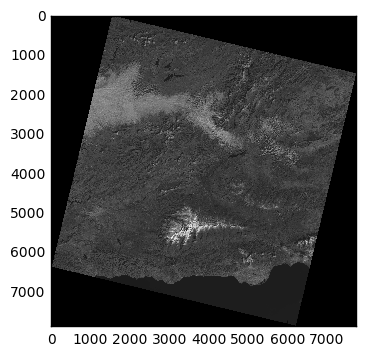

In [51]:
%matplotlib inline


import matplotlib.pyplot as plt
import rasterio
from rasterio import plot

src = rasterio.open(r'E:\Embalses\ori\20140219l8oli200_34\LC82000342014050LGN00_B5.TIF')


plot.show(src,  cmap = ('Greys_r'))



In [29]:
'''kwargs = src.meta
    kwargs.update(
        dtype=rasterio.uint8,
        count=1,
compress='lzw')'''

"kwargs = src.meta\n    kwargs.update(\n        dtype=rasterio.uint8,\n        count=1,\ncompress='lzw')"

In [30]:
from bokeh.models import Range1d
from bokeh.plotting import Figure
from bokeh.io import output_notebook, show

In [31]:
from bokeh.tile_providers import STAMEN_TONER

In [13]:
import os, rasterio
from rasterstats import zonal_stats

path = r'G:\VDCNS\protocolo\pro'
dtm = r'G:\VDCNS\Curvas_MTN_Historico\mdt_comp1.tif'

for i in os.listdir(path):
    
    npath = os.path.join(path, i)
    
    for s in os.listdir(npath):
        #print(npath)
        if s.endswith('_WaterMask.shp'):
            #print(s)
            shape = os.path.join(npath, s)
            #print(shape)


            stats_mtn_imp = zonal_stats(shape, dtm, stats=['majority', 'median', 'mean', 'max', 'min', 'range'])

            print(os.path.split(npath)[1], stats_mtn_imp[0]['median'])

        '''self.cota = stats_mtn[0]['median']

        ##Insertamos los datos en MongoDB
        connection = pymongo.MongoClient("mongodb://localhost")
        db=connection.teledeteccion
        vdcns = db.vdcns

        try:

            vdcns.update_one({'_id':self.escena}, {'$set':{'Cota': {'MTN_imp': stats_mtn_imp[0]}}}) 

        except Exception as e:

            print("Unexpected error:", type(e), e)'''


19840910l5tm202_32 300.59161376953125
19840926l5tm202_32 300.8353576660156
19850305l5tm202_32 307.22149658203125
19850812l5tm202_32 302.009521484375
19860612l5tm202_32 299.93536376953125
19860628l5tm202_32 299.69183349609375
19870412l5tm202_32 307.6809997558594
19870530l5tm202_32 308.6090087890625
19870701l5tm202_32 307.41900634765625
19870802l5tm202_32 304.42950439453125
19870903l5tm202_32 303.197998046875
19890612l4tm202_32 302.2279968261719
19890815l4tm202_32 299.9761047363281
19900810l5tm202_32 299.21502685546875
19910517l4tm202_32 306.56298828125
19990827l7etm202_32 298.21649169921875
19991201l7etm202_32 302.9167785644531
20000219l7etm202_32 298.8692626953125
20000610l7etm202_32 309.32049560546875
20000626l7etm202_32 308.0190124511719
20000712l7etm202_32 306.54150390625
20000728l7etm202_32 305.947998046875
20000813l7etm202_32 305.02252197265625
20000829l7etm202_32 304.1889953613281
20000914l7etm202_32 303.07049560546875
20001016l7etm202_32 301.11846923828125
20001117l7etm202_32 29